In [1]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

from PIL import Image
from transform_factory import resize_322, center_crop_224, imagenet_normalize, tensorize, get_spatial_transform, get_color_transform, resize_232, resize_224, PIL2Tensor
from torchvision import transforms
from expl import ExplFactory
from captum.attr import visualization as viz
from torchvision.models import resnet50, ResNet50_Weights
from captum.attr import LayerAttribution
import torch.nn.functional as F

In [2]:
T_spatial, T_inv_spatial, T_config = get_spatial_transform()
T_config

{'flip_horizon': 1, 'flip_vertical': 1, 'rot_angle': 36.833045959472656}

In [29]:
orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_18.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01443537/n01443537_605.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01614925/n01614925_13.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n02100236/n02100236_390.JPEG"


model = resnet50(weights = ResNet50_Weights.DEFAULT).eval().cuda()


orig_img = Image.open(orig_img_path)
_orig_img = tensorize(center_crop_224(resize_232(orig_img))).unsqueeze(0).cuda()

expl_method = "LayerXAct"
expl_func = ExplFactory().get_explainer(model = model, expl_method = expl_method)

# center_crop_224(resize_322(orig_img))

# center_crop_224(resize_322(center_crop_224(resize_322(orig_img))))
orig_img = center_crop_224(resize_322(orig_img))


In [30]:
img1 = center_crop_224(T_inv_spatial(resize_322(resize_224(T_spatial(resize_322(orig_img))))))




# first_output = tensorize(resize_224(T_spatial(resize_322(orig_img))))
# res = center_crop_224(T_inv_spatial(F.interpolate(first_output.unsqueeze(0), (322, 322), mode='bilinear')))

In [31]:
img2 = center_crop_224(T_inv_spatial(resize_322(T_spatial(resize_224(orig_img)))))


In [32]:
print(np.abs(np.array(orig_img) - np.array(img1)).mean())

print(np.abs(np.array(orig_img) - np.array(img2)).mean())

121.38040763180273
120.57137542517007


In [37]:
with open("./val_seed_0.npy", "rb") as f:
    filepath_list = np.load(f)


img1_error = []
img2_error = []
for img_path in filepath_list:

    orig_img = center_crop_224(resize_322(Image.open(img_path)))
    
    img1 = center_crop_224(T_inv_spatial(resize_322(resize_224(T_spatial(resize_322(orig_img))))))
    img2 = center_crop_224(T_inv_spatial(resize_322(T_spatial(resize_224(orig_img)))))
    
    img1_error.append(np.abs(np.array(orig_img) - np.array(img1)))
    img2_error.append(np.abs(np.array(orig_img) - np.array(img2)))



128.01166355761055
127.72030637489371


tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -4.3625e-05, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -2.6015e-04, -2.9091e-04, -3.1160e-04, -3.2001e-06,
         -2.7138e-04, -0.0000e+00],
        [-0.0000e+00, -6.8102e-05, -0.0000e+00, -1.5516e-04, -0.0000e+00,
         -4.4286e-05, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -4.8383e-05, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., 

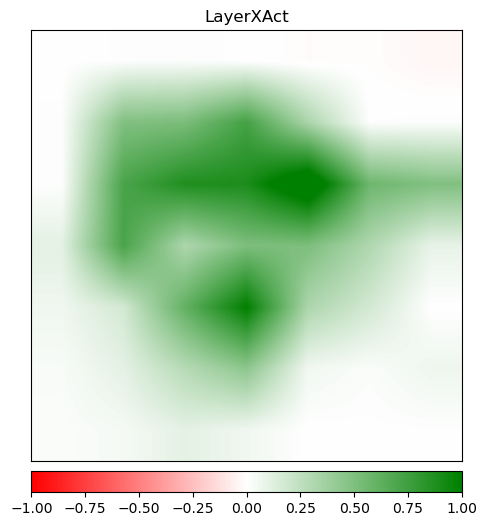

In [33]:
attr, _ = expl_func(_orig_img, "init")
print(attr[0, 0, :, :])
attr = LayerAttribution.interpolate(attr, _orig_img.shape[2:], 'bilinear')
print(attr[0, 0, :, :])

attr = np.transpose(attr.squeeze(0).cpu().detach().numpy(), (1,2,0))

# print(attr)
# plt.imshow(attr, cmap="seismic")
# plt.colorbar()
# plt.show()
# print(attr.shape)
# print(torch.sum(attr))
# plt.imshow(attr)
# plt.colorbar()
# sttr = (attr - torch.min(attr)) / (torch.max(attr) - torch.min(attr))

# rint(attr)
_ = viz.visualize_image_attr(attr, np.transpose(_orig_img.squeeze().cpu().detach().numpy(), (1,2,0)), method="heat_map", sign = 'all', show_colorbar=True, title = expl_method)